In [14]:
# %%
import pandas as pd
import weasyprint
import webbrowser
import datetime
import os
import yfinance as yf
import math
import matplotlib.pyplot as plt


def highlight_values(x):

    if isinstance(x, (int, float)):
        if x < 0:
            return 'color: red'
        elif x >= 0:
            return 'color: black'
        else:
            pass



def scan_for_csv_files(directory):
    """Scans a directory for CSV files and returns their paths.

    Args:
        directory: The directory to scan.

    Returns:
        A list of paths to CSV files found in the directory.
    """

    csv_files = []
    for file in os.listdir(directory):
        if file.endswith('.csv'):
            csv_file_path = os.path.join(directory, file)
            csv_files.append(csv_file_path)
    return csv_files

files = scan_for_csv_files(os.getcwd())
count = 0

def getData(ticker, key):
    try:
        x = str(ticker)
        sym = ""
        if (x[-1:]) == ".":
            sym += x + "L"
        else:
            sym += x + ".L"
        stock = yf.Ticker(sym)
        stock= stock.info

        return stock[key]

    except:
        pass


def getSector(ticker):
    x = getData(ticker, 'sector')
    return x
def getDividendYield(ticker):
    x =getData(ticker, 'dividendYield')
    if not x ==  None:
        return ("{:.2f}".format(x*100))
    else:
        pass




# for csv in files:



df = pd.read_csv("shares.csv")
pd.set_option('display.width', 300)




df.columns = df.columns.str.strip('\ufeff')
df['Qty'] = df['Qty'].astype('Int64').astype('string')

df = df.drop(columns=['Day Gain/Loss', 'Day Gain/Loss %', 'Market Value £'])
df["Gain/Loss %"] = df["Gain/Loss %"].str.rstrip("%").astype('float')

totals = df.tail(2)
df.drop(df.tail(2).index,inplace=True)







In [15]:
df['Sector'] = df['Symbol'].apply(getSector)

In [16]:
df["Dividend Yield"] = df['Symbol'].apply(getDividendYield)

In [17]:
df = df.sort_values(by="Gain/Loss %", ascending=False)

In [18]:
result = pd.concat([df,totals])
# result = result.fillna('')



In [19]:
result['Market Value'] = result['Market Value'].str.replace('£', '')
result['Market Value'] = result['Market Value'].str.replace(',', '')
result['Market Value'] = result['Market Value'].astype('float')

In [20]:
result['Gain/Loss']= result["Gain/Loss"].str.replace('£', '')
result['Gain/Loss']= pd.to_numeric(result["Gain/Loss"].str.replace(',', '') ,errors='coerce')



In [21]:
result['Gain/Loss %']= pd.to_numeric(result["Gain/Loss %"],errors='coerce')

In [22]:
result = result.reset_index(drop=True)
result = result.fillna('')

In [23]:
result['Gain/Loss'] = pd.to_numeric(result['Gain/Loss'], errors='coerce')
result['Gain/Loss %'] = pd.to_numeric(result['Gain/Loss %'], errors='coerce')
result['Market Value'] = pd.to_numeric(result['Market Value'], errors='coerce')

In [24]:
# Apply styling with proper formatting
def custom_format(x, column_name=''):
    if isinstance(x, str):
        return x
    elif pd.isna(x):  # Check if the value is NaN
        return ''  # Return an empty string for NaN
    elif isinstance(x, (int, float)):  # Check if it's a number
        # Apply custom formatting for 'Gain/Loss' and 'Market Value'
        if column_name == 'Gain/Loss' or column_name == 'Market Value':
            return f'£{x:,.2f}'  # Format with comma separator and 2 decimal places
        elif column_name == 'Gain/Loss %':
            return f'{x:.2f}%'  # Format as percentage
    return x  # Default return for other types

# Apply styling with proper formatting using a conditional function
styled = result.style.format({
    'Gain/Loss': lambda x: custom_format(x, 'Gain/Loss'),
    'Gain/Loss %': lambda x: custom_format(x, 'Gain/Loss %'),
    'Market Value': lambda x: custom_format(x, 'Market Value'),
    }).applymap(highlight_values, subset=['Gain/Loss', 'Gain/Loss %'])

/tmp/ipykernel_17559/2824366532.py:20: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  }).applymap(highlight_values, subset=['Gain/Loss', 'Gain/Loss %'])


In [25]:
newdf = df
newdf['Market Value'] = newdf['Market Value'].str.replace('£', '')
newdf['Market Value'] = newdf['Market Value'].str.replace(',', '')
newdf['Market Value'] = newdf['Market Value'].astype('float')

In [26]:

sector_market_value = newdf.groupby('Sector')['Market Value'].sum()

In [27]:
sector_market_value

Sector
Basic Materials            1009.76
Communication Services      722.57
Consumer Cyclical         16360.70
Consumer Defensive        11645.57
Energy                     3689.80
Financial Services         8569.29
Healthcare                 1749.11
Industrials               25117.65
Technology                   20.53
Utilities                  2922.69
Name: Market Value, dtype: float64

/tmp/ipykernel_17559/497670689.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pct_value = sector_market_value[i] / sum(sector_market_value) * 100


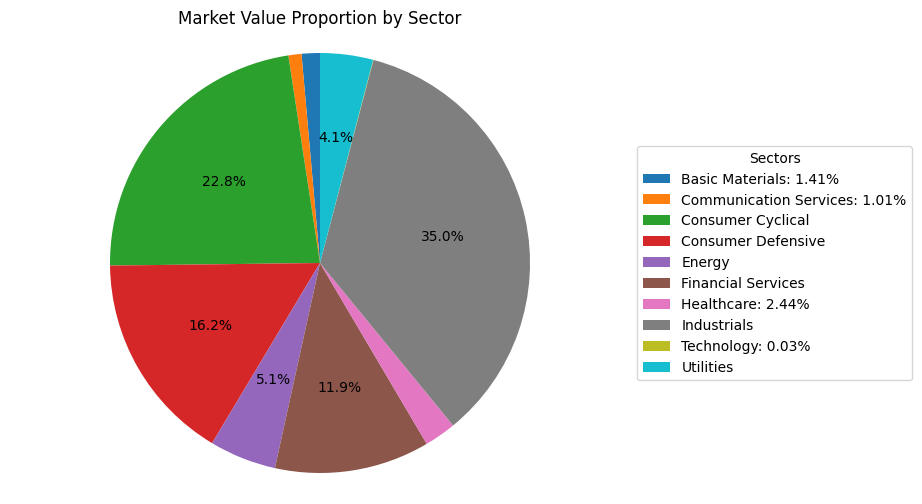

In [42]:
plt.figure(figsize=(8, 6))
def custom_autopct(pct):
    return ('%.1f%%' % pct) if pct >= 4 else ''
wedges, texts, autotexts = plt.pie(sector_market_value, autopct=custom_autopct, startangle=90)

total = sum(sector_market_value)
percentages = [value / total * 100 for value in sector_market_value]

# Create custom labels for the legend
legend_labels = []

# Create legend labels using a for loop
for i in range(len(sector_market_value.index)):
    name = sector_market_value.index[i]
    pct = percentages[i]
    if pct <= 4:
        legend_labels.append(f'{name}: {pct:.2f}%')
    else:
         legend_labels.append(f'{name}')


# For percentages below 4%, set the labels manually to be outside the pie chart
for i, autotext in enumerate(autotexts):
    pct_value = sector_market_value[i] / sum(sector_market_value) * 100
    if pct_value < 4:
        # Move the label slightly further outside the pie slice
        autotext.set_position((1.1, autotext.get_position()[1]))

plt.title('Market Value Proportion by Sector')

plt.legend(wedges, legend_labels, title="Sectors", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')

plt.savefig('market_value_pie_chart.pdf', format='pdf', bbox_inches='tight')
# ')  # Equal aspect ratio ensures the pie chart is circular
plt.show()

<Figure size 640x480 with 0 Axes>

In [39]:
HTML_TEMPLATE2 = '''
</body>
</html>
'''
with open('small-template.html', 'r', encoding='utf-8') as smallTemplate:
    small_template = smallTemplate.read()
with open('bob-template.html', 'r', encoding='utf-8') as smallTemplate:
    bob_template = smallTemplate.read()

def to_html_pretty(df, html_template,filename='out.html', title=''):

    ht = ''

    ht += df.to_html(classes='wide', escape=False, index=False)
    if title != '':
        ht += '<div> %s </div>\n' % title

    with open(filename, 'w', encoding='utf-8') as f:
        f.write(html_template+ ht + HTML_TEMPLATE2)

# Pretty print the dataframe as an html table to a file
intermediate_html = 'intermediate.html'

x = datetime.datetime.now()
title = 'Updated: ' + x.strftime('%b') + ' ' + x.strftime('%y')

# Normal html:
to_html_pretty(styled,small_template,intermediate_html, title )
# Bob template:

# if you do not want pretty printing, just use pandas:
# result.to_html(intermediate_html)

# Convert the html file to a pdf file using weasyprint

out_pdf= os.path.basename(os.path.normpath('shares.csv')).replace('.csv', '') + '.pdf'
# weasyprint.HTML(intermediate_html).write_pdf(out_pdf)
weasyprint.HTML('intermediate.html').write_pdf('shares.pdf')




to_html_pretty(styled,bob_template,intermediate_html, title )
weasyprint.HTML('intermediate.html').write_pdf('bob.pdf')
#  webbrowser.open_new_tab("/tmp/intermediate.html")


# This is the table pretty printer used above: